In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import bioframe
import numpy as np
from pybedtools import BedTool
import re


import matplotlib
import os


figure_width = 5
matplotlib.rcParams['font.size'] = 10
saveFigs = True 
if saveFigs == True:
    figure_path = '../figs/figure2/'
    os.makedirs(figure_path, exist_ok=True)
    # to save inkscape-friendly svgs
    new_rc_params = {'text.usetex': False,
                     "svg.fonttype": 'none'}
    matplotlib.rcParams.update(new_rc_params)


In [2]:
gm_df = pd.read_csv('../annotations/GM12878_hg38_25kb.tsv', sep = '\t')
im_df = pd.read_csv('../annotations/IMR90_hg38_25kb.tsv', sep = '\t')

In [3]:
chrom_hmm_dir = '/pollard/data/wynton/consortia/roadmap/byFileType/chromhmmSegmentations/ChmmModels/coreMarks/jointModel/final'

In [4]:
gm_chrom =  chrom_hmm_dir+'/E116_15_coreMarks_hg38lift_dense.bed.gz'
im_chrom =  chrom_hmm_dir+'/E017_15_coreMarks_hg38lift_dense.bed.gz'


In [5]:
gm_chrom_df = BedTool(gm_chrom).to_dataframe(skiprows=1)
im_chrom_df = BedTool(im_chrom).to_dataframe(skiprows=1)

In [6]:
from bioframe.util import bedtools
def bedtools_intersect_basePairs(left, right, rsuffix='_', **kwargs):
    """
    >>> ixn = bedtools_intersect(bed1, bed2, wao=True), needed to delete other keys b/c they clashed
   """
    
    out = bedtools.intersect(a=left, b=right,wao=True)
    out.columns = list(left.columns) + [c+rsuffix if c in left.columns else c for c in right.columns] + ['bpOverlap']
    return out

In [7]:
gm_inter = bedtools_intersect_basePairs(gm_df, gm_chrom_df)
im_inter = bedtools_intersect_basePairs(im_df, im_chrom_df)

/pollard/home/lchumpitaz/miniconda3/envs/HC2/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (21,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  


In [8]:
def bp_over_state(inter_df, hmm_track, hmm_state='HMM3', chrom=None, chrom_state = None, normalize = True, n_states=None, bp=True):
    
    binsize = hmm_track['end'][0]-hmm_track['start'][0]
    
    if n_states == None:
        n_states = inter_df[hmm_state].unique()
        n_states = n_states[n_states == n_states]
        n_states.sort()
    
    
    mask = (inter_df['start']!=-1)& (inter_df['start_']!=-1) & (~inter_df.E1.isna())
    
    if chrom_state:        
        mask = mask & (inter_df['name']==chrom_state)
    
    if chrom:
        mask= mask & (inter_df['chrom']==chrom)
        hmm_track= hmm_track[hmm_track['chrom'] == chrom]
    
    if bp:
        total_nucleotides = inter_df['bpOverlap']
        
    else:
        total_nucleotides = (inter_df['end_'] - inter_df['start_'])
    
    results = []
    
    if normalize:
        
        for state in n_states:
            score = total_nucleotides[(inter_df[hmm_state]==state) & mask].sum()
            p = hmm_track[hmm_track[hmm_state]==state]
            score = score/(p['end'] - p['start']).sum()
            results.append(score)
        
        return np.array(results)/(total_nucleotides[mask].sum()/(hmm_track['end'] - hmm_track['start']).sum() )
    
    else:
        return np.array([total_nucleotides[(inter_df[hmm_state]==state) & mask].sum()/(binsize*len(hmm_track[hmm_track[hmm_state]==state])) for state in n_states])

In [9]:
def state_percentage(inter_df, hmm_track, hmm_state='HMM3', chrom_state = None, n_states=None, bp=True):
    
    binsize = hmm_track['end'][0]-hmm_track['start'][0]
    
    if n_states == None:
        n_states = inter_df[hmm_state].unique()
        n_states = n_states[n_states == n_states]
        n_states.sort()
    
    
    
    mask = (inter_df['start']!=-1)& (inter_df['start_']!=-1) & (~inter_df[hmm_state].isna())
    
    if chrom_state:        
        mask = mask & (inter_df['name']==chrom_state)
    
    
    if bp:
        total_nucleotides = inter_df['bpOverlap']
        
    else:
        total_nucleotides = (inter_df['end_'] - inter_df['start_'])
        
    results = []
    for state in n_states:
        results.append(total_nucleotides[(inter_df[hmm_state]==state) & mask].sum()/total_nucleotides[mask].sum())
    
    return results

In [10]:
def state_percentage_columns(inter_df, hmm_track, hmm_state='HMM3', chrom_state = None, n_states=None, bp=True):
    
    binsize = hmm_track['end'][0]-hmm_track['start'][0]
    
    if n_states == None:
        n_states = inter_df[hmm_state].unique()
        n_states = n_states[n_states == n_states]
        n_states.sort()
    
    
    
    mask1 = (inter_df['start']!=-1)& (inter_df['start_']!=-1) & (~inter_df[hmm_state].isna())
    
    if chrom_state:        
        mask2 = mask1 & (inter_df['name']==chrom_state)
    
    
    if bp:
        total_nucleotides = inter_df['bpOverlap']
        
    else:
        total_nucleotides = (inter_df['end_'] - inter_df['start_'])
        
    results = []
    for state in n_states:
        score = total_nucleotides[(inter_df[hmm_state]==state) & mask2].sum()
        score = score/total_nucleotides[(inter_df[hmm_state]==state) & mask1].sum()
        results.append(score)
    
    return results

In [11]:
chrom_states = list(gm_chrom_df.name.unique())
chrom_states.sort(key=lambda x:int(re.findall('[0-9]+', x)[0]))
chrom_states

['1_TssA',
 '2_TssAFlnk',
 '3_TxFlnk',
 '4_Tx',
 '5_TxWk',
 '6_EnhG',
 '7_Enh',
 '8_ZNF/Rpts',
 '9_Het',
 '10_TssBiv',
 '11_BivFlnk',
 '12_EnhBiv',
 '13_ReprPC',
 '14_ReprPCWk',
 '15_Quies']

In [12]:
hmm_states = ['B', 'Mbb', 'M', 'Maa', 'A']

In [13]:
state_percentage(gm_inter, gm_df, hmm_state='HMM3P', chrom_state = '14_ReprPCWk', n_states=None, bp=True)

[0.14793193892249482,
 0.05428415405232447,
 0.18869136023138827,
 0.2532490445343458,
 0.35584350225944666]

In [14]:
def get_chrom_scores(inter_df, hmm_df, hmm_states, chrom_states, hmm_state='HMM3P', normalize=True):
    scores_list = []
    for chrom_state in chrom_states:
        score = bp_over_state(inter_df, hmm_df,  hmm_state ,None, chrom_state, normalize)
        scores_list.append(score)
                           
    return np.array(scores_list)

In [15]:
def get_chrom_percentages(inter_df, hmm_df, hmm_states, chrom_states, column=False, hmm_state='HMM3P'):
    scores_list = []
    for chrom_state in chrom_states:
        if column:
            score = state_percentage_columns(inter_df, hmm_df,  hmm_state , chrom_state)
        else:
            score = state_percentage(inter_df, hmm_df,  hmm_state , chrom_state)
            
        scores_list.append(score)
                           
    return np.array(scores_list)

In [16]:
annotation = 'HMM3P'
gm_scores = get_chrom_scores(gm_inter,gm_df, hmm_states, chrom_states, hmm_state=annotation)
im_scores = get_chrom_scores(im_inter,im_df, hmm_states, chrom_states, hmm_state=annotation)

In [17]:
gm_percentages = get_chrom_percentages(gm_inter,gm_df, hmm_states, chrom_states, hmm_state=annotation)
im_percentages = get_chrom_percentages(im_inter,im_df, hmm_states, chrom_states, hmm_state=annotation)

In [18]:
gm_percentages_c = get_chrom_percentages(gm_inter,gm_df, hmm_states, chrom_states, column=True,hmm_state=annotation)
im_percentages_c = get_chrom_percentages(im_inter,im_df, hmm_states, chrom_states, column=True, hmm_state=annotation)

In [19]:
def score_heatmap(scores, hmm_states, chrom_states, cmap='bwr', vmin=0, vmax=2):
    
    fig = plt.figure(figsize =(7, 10))
    ax = fig.add_subplot(111)
        
    im = ax.matshow(scores, cmap=cmap, vmin=vmin, vmax=vmax)
    ticks = np.arange(0,scores.shape[0],1)
    ax.set_yticks(ticks)
    ax.set_yticklabels(chrom_states)

    ax.set_xticks(np.arange(0, len(hmm_states), 1))
    ax.set_xticklabels(hmm_states)

    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            text = ax.text(j, i, np.round(scores[i, j], 2),
                           ha="center", va="center", color="black")
            
    plt.colorbar(im, fraction=0.02, pad=0.04)

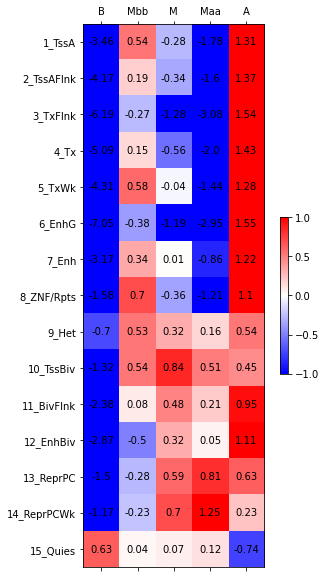

In [20]:
score_heatmap(np.log2(gm_scores), hmm_states, chrom_states, vmin=-1, vmax=1)
if saveFigs:
    plt.savefig(figure_path+'GM12878_ChromHMM_'+annotation+'.svg', bbox_inches='tight')

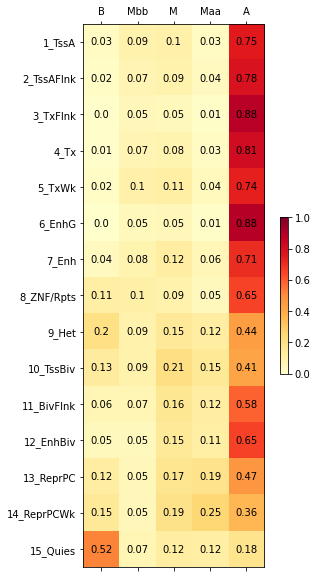

In [21]:
score_heatmap(gm_percentages, hmm_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

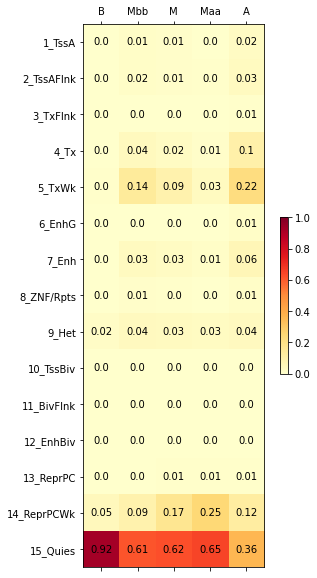

In [22]:
score_heatmap(gm_percentages_c, hmm_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [23]:
gm_percentages_c.sum(axis=0)

array([1., 1., 1., 1., 1.])

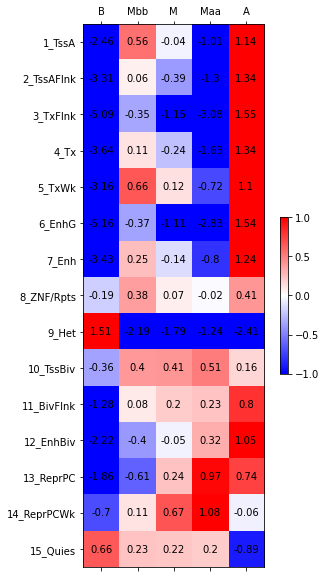

In [24]:
score_heatmap(np.log2(im_scores), hmm_states, chrom_states, vmin=-1, vmax=1)
plt.savefig(figure_path+'IMR90_ChromHMM_'+annotation+'.svg', bbox_inches='tight')

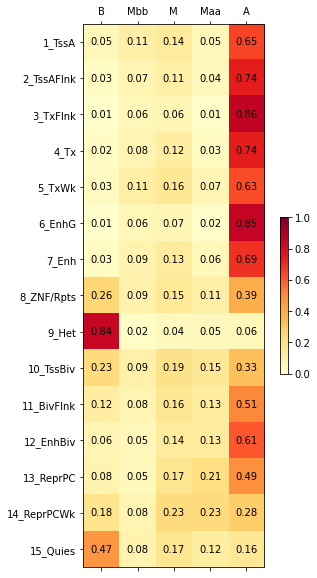

In [25]:
score_heatmap(im_percentages, hmm_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

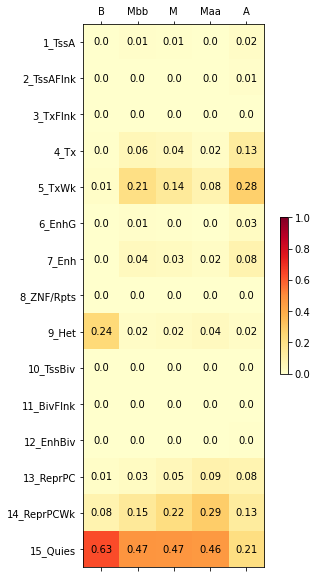

In [26]:
score_heatmap(im_percentages_c, hmm_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [27]:
# gm_rao_df = BedTool('/pollard/home/lchumpitaz/Hi-C/testing/Rao_calls/GSE63525_GM12878_subcompartments.bed.gz').to_dataframe(skiprows=1)
# rao_inter = bedtools_intersect_basePairs(gm_df, gm_rao_df)
# rao_states = gm_rao_df.name.unique()
# rao_states  = rao_states[rao_states==rao_states]
# rao_states.sort()
# rao_percentages = get_chrom_percentages(rao_inter, gm_df, hmm_states, rao_states)
# rao_scores = get_chrom_scores(rao_inter,gm_df, hmm_states, rao_states)


In [28]:
# score_heatmap(rao_percentages, hmm_states, rao_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [29]:
#score_heatmap(rao_scores, hmm_states, rao_states)

In [30]:
# rao_chrom_inter = bedtools_intersect_basePairs(gm_rao_df, gm_chrom_df)
# rao_chrom_inter.rename(columns={'name':'states', 'name_':'name'}, inplace=True)
# rao_chrom_percentages = get_chrom_percentages(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states')
# rao_chrom_percentages_c = get_chrom_percentages(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states', column=True)

In [31]:
# score_heatmap(rao_chrom_percentages, rao_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [32]:
# score_heatmap(rao_chrom_percentages_c, rao_states, chrom_states, cmap='YlOrRd',vmin = 0 , vmax = 1)

In [33]:
# gm_rao_df.rename(columns={'name':'states'}, inplace=True)
# rao_chrom_scores = get_chrom_scores(rao_chrom_inter, gm_rao_df, rao_states, chrom_states, hmm_state='states')

In [34]:
# score_heatmap(rao_chrom_scores, rao_states, chrom_states)